# Kalman Filter

In [130]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings("ignore")
from fredapi import Fred
import statsmodels.formula.api as smf
import datetime

In [131]:
interest = pd.read_csv('hw2_data.csv', parse_dates = True, index_col = 0)
interest

,I_US,I_EU,Inf_US,Inf_EU,Euro
2003-12-01,1.11,2.1590,0.019284,0.021933,1.196501
2004-01-01,1.10,2.1463,0.020352,0.020207,1.258194
2004-02-01,1.06,2.0895,0.020263,0.018343,1.246805
2004-03-01,1.05,2.0706,0.016885,0.016654,1.244803
2004-04-01,1.05,2.0288,0.017401,0.017175,1.236507
...,...,...,...,...,...
2022-08-01,2.50,0.0366,0.084821,0.088662,1.020825
2022-09-01,2.76,0.3947,0.082492,0.091406,1.003905
2022-10-01,3.21,1.0109,0.082224,0.099272,0.982956
2022-11-01,3.85,1.4277,0.077631,0.106206,0.988631


In [132]:
exrate = pd.read_csv('hw2_data.csv', parse_dates = True, index_col = 0)[['Euro']]
exrate

,Euro
2003-12-01,1.196501
2004-01-01,1.258194
2004-02-01,1.246805
2004-03-01,1.244803
2004-04-01,1.236507
...,...
2022-08-01,1.020825
2022-09-01,1.003905
2022-10-01,0.982956
2022-11-01,0.988631


In [133]:
interest.isnull().sum()

I_US      0
I_EU      0
Inf_US    0
Inf_EU    0
Euro      0
dtype: int64

In [134]:
def scale(x):
    return (x-x.min())/(x.max()-x.min())

interest["ir_diff"] = scale(interest["I_US"]) - scale(interest["I_EU"])
interest.dropna(inplace= True)

In [135]:
interest

,I_US,I_EU,Inf_US,Inf_EU,Euro,ir_diff
2003-12-01,1.11,2.1590,0.019284,0.021933,1.196501,-0.292402
2004-01-01,1.10,2.1463,0.020352,0.020207,1.258194,-0.292024
2004-02-01,1.06,2.0895,0.020263,0.018343,1.246805,-0.289458
2004-03-01,1.05,2.0706,0.016885,0.016654,1.244803,-0.287991
2004-04-01,1.05,2.0288,0.017401,0.017175,1.236507,-0.280651
...,...,...,...,...,...,...
2022-08-01,2.50,0.0366,0.084821,0.088662,1.020825,0.337677
2022-09-01,2.76,0.3947,0.082492,0.091406,1.003905,0.322946
2022-10-01,3.21,1.0109,0.082224,0.099272,0.982956,0.298081
2022-11-01,3.85,1.4277,0.077631,0.106206,0.988631,0.343414


In [176]:
k = 0.4
z = 1.645
T = 20

interest["Filter"] = interest.ir_diff.ewm(alpha = k, adjust = False).mean()
interest["Filter Error"] = interest.ir_diff - interest["Filter"]

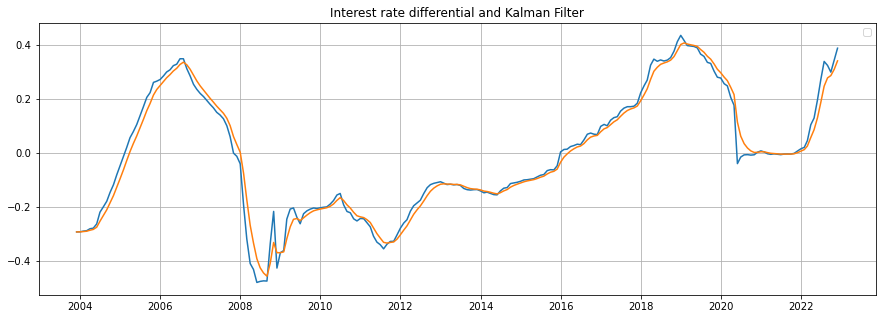

In [177]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.title("Interest rate differential and Kalman Filter")
plt.plot(interest.ir_diff)
plt.plot(interest.Filter)
plt.legend("Int. rate differential", "Kalman Filter")
plt.grid()

In [178]:
interest2 = interest[["ir_diff", "Filter", "Filter Error"]].copy()
interest2["E_bar"] = interest2["Filter Error"].expanding(T).mean()
interest2["mu_t"] = interest2["Filter Error"].rolling(T).mean()
interest2["var_t"] = interest2["Filter Error"].expanding(T).std()
interest2["Test Statistic"] = interest2["mu_t"]/(interest2["var_t"]/np.sqrt(T))

In [179]:
interest2["Signal"] = 0
for i in interest2.index:
    # create signals based on the sign of the current mean and if we fail to reject the null
    if (interest2.loc[i, "Test Statistic"] < z) & (interest2.loc[i, "E_bar"] >= 0):
        interest2.loc[i, "Signal"] = 1
    elif (interest2.loc[i, "Test Statistic"] > -z) & (interest2.loc[i, "E_bar"] < 0):
        interest2.loc[i, "Signal"] = -1

interest2.dropna(inplace = True)
interest2.head()

,ir_diff,Filter,Filter Error,E_bar,mu_t,var_t,Test Statistic,Signal
2005-07-01,0.136397,0.091784,0.044613,0.028814,0.028814,0.019803,6.507075,0
2005-08-01,0.170107,0.123113,0.046994,0.029680,0.031164,0.019705,7.072688,0
2005-09-01,0.204844,0.155805,0.049038,0.030560,0.033604,0.019668,7.640918,0
2005-10-01,0.222203,0.182364,0.039839,0.030963,0.035512,0.019313,8.223234,0
2005-11-01,0.260255,0.213521,0.046734,0.031620,0.037755,0.019161,8.811908,0


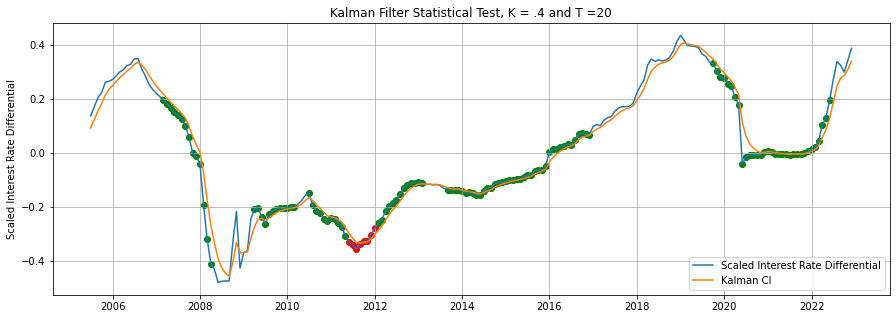

In [180]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter Statistical Test, K = .4 and T ="+str(T))

ax.set_ylabel("Scaled Interest Rate Differential")
ax.plot(interest2["ir_diff"])
ax.plot(interest2["Filter"])

ax.scatter(interest2[interest2.Signal == 1].index, interest2[interest2.Signal == 1]["ir_diff"], color = "green")
ax.scatter(interest2[interest2.Signal == -1].index, interest2[interest2.Signal == -1]["ir_diff"], color = "red")

ax.legend(["Scaled Interest Rate Differential", "Kalman CI"])

ax.grid()

In [181]:
drange = pd.date_range(start =interest2.index[0], end = "01/01/2023")
daily  = pd.DataFrame(index = drange)

daily["Signal"] = interest2["Signal"]
daily["Filter"] = interest2["Filter"]
daily["Filter"] = daily["Filter"].ffill()
daily["ir_diff"] = interest2["ir_diff"]
daily["ir_diff"] = daily["ir_diff"].ffill()
daily = daily.fillna(0)

i = 30
daily[str(i)+"_signal"] = 0
for j in daily.index:
    if daily.loc[j,"Signal"] != 0:
        daily.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = daily.loc[j, "Signal"]

In [182]:
drange = pd.date_range(start =interest2.index[0], end = "01/01/2023")
exdf = pd.DataFrame(index = drange)

exdf["EURUSD"] = exrate
exdf["EURUSD"] = exdf["EURUSD"].ffill()

daily["EURUSD"] = exdf["EURUSD"]
daily["Returns"] = np.log(daily["EURUSD"]).diff()

In [183]:
s = i
daily[str(s)+"_returns"] = (np.exp((daily[str(i)+"_signal"].shift()*daily.Returns).cumsum())-1)
daily[str(s)+"_success"] = ((daily[daily.Signal!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)
daily.head()

,Signal,Filter,ir_diff,30_signal,EURUSD,Returns,30_returns,30_success
2005-07-01,0.0,0.091784,0.136397,0,1.193602,NaN,NaN,NaN
2005-07-02,0.0,0.091784,0.136397,0,1.193602,0.0,0.0,NaN
2005-07-03,0.0,0.091784,0.136397,0,1.193602,0.0,0.0,NaN
2005-07-04,0.0,0.091784,0.136397,0,1.193602,0.0,0.0,NaN
2005-07-05,0.0,0.091784,0.136397,0,1.193602,0.0,0.0,NaN


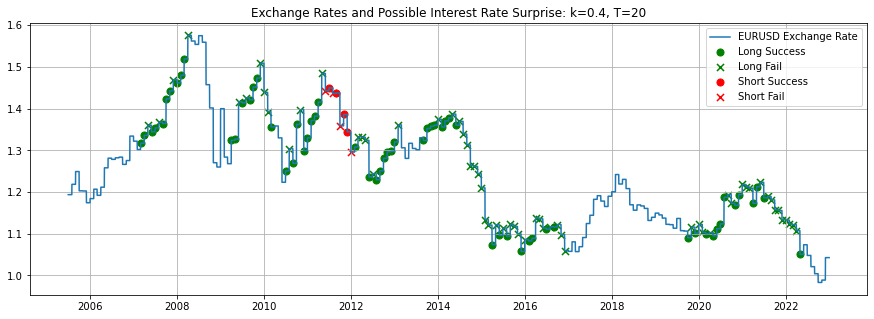

In [184]:
plt.figure(figsize = (15, 5))
plt.title("Exchange Rates and Possible Interest Rate Surprise:"+ " k=" + str(k)+", T="+str(T))
plt.plot(daily["EURUSD"])

longsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["Signal"] == 1)]
longfail = daily[(daily[str(s)+"_success"] == 0) & (daily["Signal"] == 1)] 
shortsuccess = daily[(daily[str(s)+"_success"] == 1) & (daily["Signal"] == -1)]
shortfail = daily[(daily[str(s)+"_success"] == 0) & (daily["Signal"] == -1)]

plt.scatter(longsuccess.index, longsuccess["EURUSD"], color = 'green', s = 50)
plt.scatter(longfail.index, longfail["EURUSD"], color = 'green', s = 50, marker = "x")
plt.scatter(shortsuccess.index, shortsuccess["EURUSD"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["EURUSD"], color = 'red', s = 50, marker = "x")

plt.legend(["EURUSD Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
plt.grid()

In [185]:
mret = str(i)+"_returns"

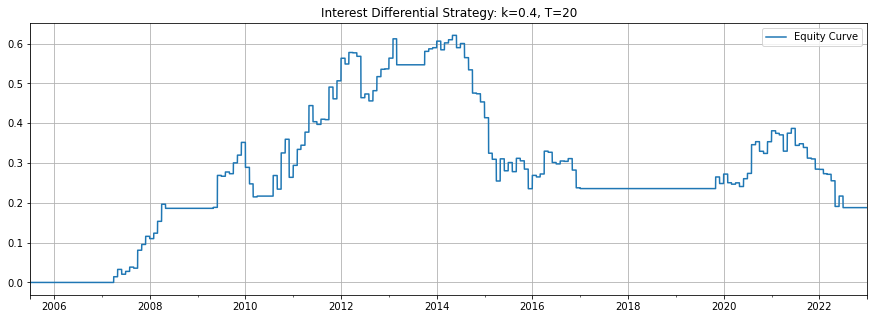

In [186]:
plt.figure(figsize = (15, 5))
d2 = daily[daily.index.year >= 2020]
(daily[mret].dropna()).plot()
plt.title("Interest Differential Strategy:"+ " k=" + str(k)+", T="+str(T))
plt.legend(["Equity Curve", "Long Success", "Long Fail", "Short Success", "Short Fail"])
plt.grid()

In [187]:
### Binomial Test
start = daily[["EURUSD", mret, "30_signal"]][123:].index[0]
df = daily[daily.Signal != 0][["30_signal", "EURUSD"]].copy()
df['D'] = df["30_signal"]

In [188]:
df = df[:-2].copy()

In [189]:
df = df[:-2].copy()
df['s_current'] = daily[daily.index.isin(df.index)]["EURUSD"].values
df['s_future'] = daily[daily.index.isin(df.index+datetime.timedelta(30))]["EURUSD"].values
df['R'] = np.where(df['s_future'] >= df['s_current'], 1, -1)

In [190]:
df['W'] = (df['D']-np.mean(df['D']))*(df['R']-np.mean(df['R']))
T_B = np.mean(df['W'])
T_B

0.013392026784053677

In [191]:
dy = df['W'] - np.mean(df['W'])
gamma_0 = sum((dy)**2)/len(df)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [192]:
from scipy.stats import norm

statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  0.4411994648638108 , 5 % critical value :  1.64


In [193]:
### Weighted Binomial Test
df['W_2'] = df['D']*(df['s_future']-df['s_current'])
T_WB = np.mean(df['W_2'])
T_WB

0.002175893370560774

In [194]:
dy_2 = df['W_2'] - np.mean(df['W_2'])
gamma_0 = sum((dy_2)**2)/len(df)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(df)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

In [195]:
statistic_2 = T_WB/np.sqrt(LRV_2/len(df))
print('Test statistic : ', statistic_2, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  1.138157936045619 , 5 % critical value :  1.64


**Changing values**